# <font color='#4C5FDA'>**Segmentación de imágenes vasculares de la retina** </font> <a name="tema1">

1. Instalamos [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch), una librería que nos permite usar arquitecturas de modelos para clasificación binaria y multiclase. Además de encoders preentrenados.

In [1]:
#@title **Paquetes necesarios**
! pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
import torch
import torch.nn as nn

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Manipulación de datos (imágenes)
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Data agumentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Barra de carga
from tqdm import tqdm

# Loss function
import segmentation_models_pytorch as smp


## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaglle.

In [3]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [6]:
!mkdir ~/kaggle

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Retina Blood Vessel](https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel)
 desde kaggle.

 The dataset comprises a total of X high-resolution retinal fundus images captured using state-of-the-art imaging equipment. Each image comes with corresponding pixel-level ground truth annotations indicating the exact location of blood vessels. These annotations facilitate the development and evaluation of advanced segmentation algorithms.

 Use Cases:
 - Algorithm Development: Use the dataset to train and test innovative segmentation algorithms, leveraging the precise annotations to achieve accurate and reliable results.
 - Disease Detection: Create models that can assist in the early detection of retinal pathologies, contributing to timely medical interventions.

In [ ]:
! kaggle datasets download -d abdallahwagih/retina-blood-vessel
! unzip retina-blood-vessel.zip

Annotations: For each image, corresponding pixel-wise annotations in a binary mask format are provided. Blood vessel pixels are marked as 1, while background pixels are labeled as 0.

### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [5]:
class RetinaDataset(Dataset):
  def __init__(self, image_dir: str, mask_dir: str, transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen y la pasamo a RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0

    """ Carga de la máscara """

    # Entramos a la carpeta y conseguimos la mascara de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la mascara
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ image: data/train_images/0cdf5b5d0ce1_01.jpg """
    """ mask: data/train_masks/0cdf5b5d0ce1_01.png """
    mask_path = os.path.join(self.mask_dir, self.images[index])

    # Leemos la mascara en escala de grises
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Binarizamos la mascara
    mask = np.where(mask<127, 0, 1).astype(np.int16)

    """ Data augmentation """
    if self.transform:
      # Aplicamos las transformaciones a la máscara e imagen
      augmentations = self.transform(image=img, mask=mask)

      # Lo anterior nos devuelve un diciconario, entonces conseguimos la máscara e imagen de ese diccionario
      img, mask = augmentations['image'], augmentations['mask']
      img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
      mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

    return img, mask

### <font color='#52F17F'>**Visualización de datos**</font>

In [9]:
""" Función para visualizar imágen y máscara """
def visualize_data(dataset, size=4):
  plt.figure(figsize=(12, size*4))
  for i in range(1, size*2 + 1, 2): # 1, 3, 5, 7
      img = dataset[i][0]
      mask = dataset[i][1]
      plt.subplot(size, 2, i); plt.imshow(img)
      plt.subplot(size, 2, i + 1); plt.imshow(mask, cmap='gray')
  plt.show()

In [11]:
TRAIN_IMAGES_PATH = "Data/train/image"
TRAIN_MASKS_PATH = "Data/train/mask"
TEST_IMAGES_PATH = "Data/test/image"
TEST_MASKS_PATH = "Data/test/mask"
train_dataset = RetinaDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH)
test_dataset = RetinaDataset(TEST_IMAGES_PATH, TEST_MASKS_PATH)

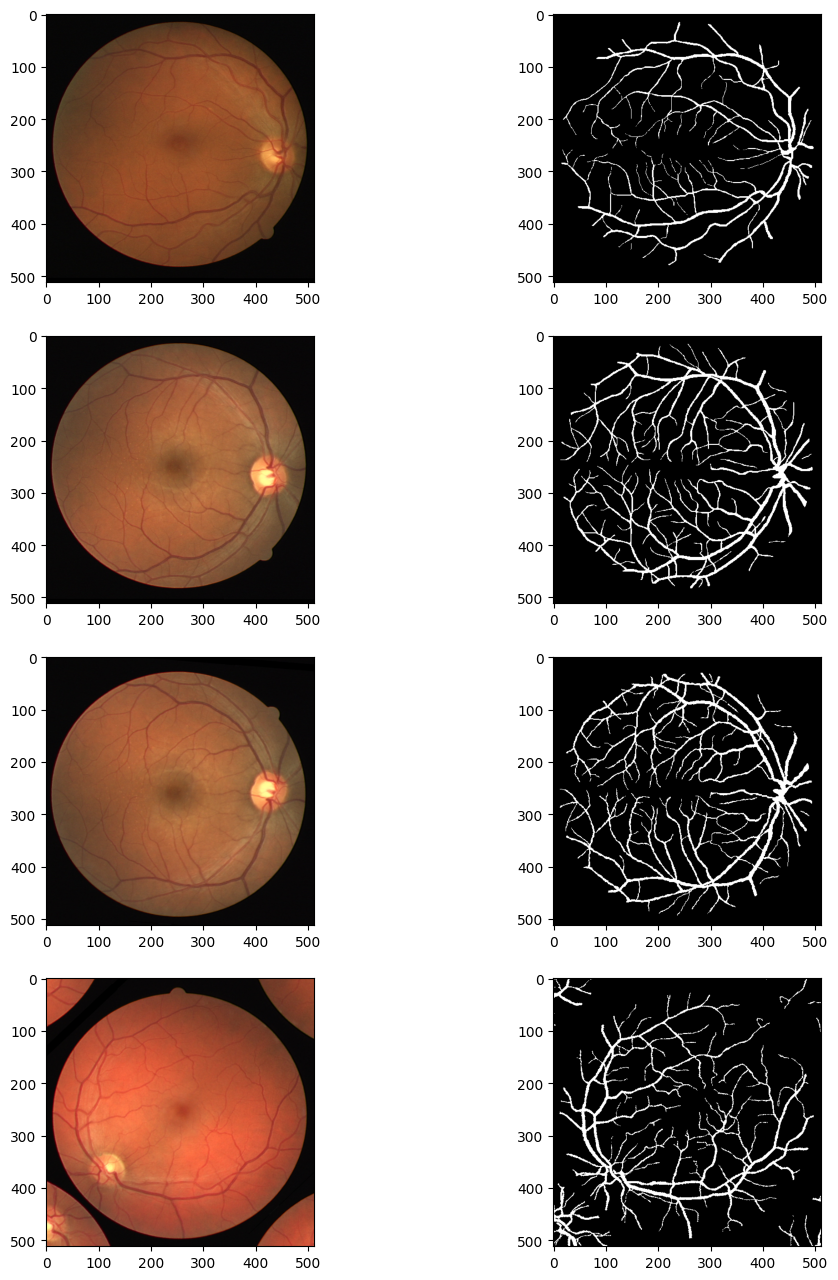

In [12]:
visualize_data(train_dataset)

### <font color='#52F17F'>**Data augmentation**</font>

In [13]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

train_transform = A.Compose([
  A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
  A.Rotate(limit=35, p=1.0),
  A.HorizontalFlip(p=0.5),
  A.VerticalFlip(p=0.1)
])

test_transform = A.Compose([
  A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH)
])

## <font color='#ECA702'>**Modelo CNN**</font>

**U-net architecture**

The network architecture is illustrated in Figure 1. It consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels
in every convolution. At the final layer a 1x1 convolution is used to map each
64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

<div align="center"> <image src="https://imgs.search.brave.com/6lbIK-xzYuzh28AextLXfu6l0sxRrVbSexgE3eSLp_Q/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZWVrc2Zvcmdl/ZWtzLm9yZy93cC1j/b250ZW50L3VwbG9h/ZHMvMjAyMjA2MTQx/MjEyMzEvR3JvdXAx/NC5qcGc" width=600>  </div>


### <font color='#52F17F'>**Creando el modelo**</font>

In [14]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
     super().__init__()
     #Declara las capas necesarias para realizar la doble convolución descrita en
     # el diagrama de la UNet
     self.double_conv = nn.Sequential(
         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
         nn.ReLU(inplace=True),
         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
         nn.ReLU(inplace=True)
     )

  def forward(self, x):
    return self.double_conv(x)


class Downscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv = DoubleConvBlock(in_channels, out_channels)

  def forward(self, x):
    p = self.pool(x)
    down = self.conv(p)
    return x, down


class Upscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    ## Declara las capas necesarias para aumentar la escala de los mapas de caracteristicas
    ## Puedes emplear interpolación o convolución transpuesta para lograrlo
    self.up_conv = nn.ConvTranspose2d(in_channels, in_channels//2, 2, stride=2)
    self.conv = DoubleConvBlock(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up_conv(x1)
    x = torch.cat([x1, x2], 1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x):
    return self.conv(x)

In [15]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes

    ## Siguiendo la estructura de la Unet, crea el modelo con los bloques declarados arriba
    self.inc = DoubleConvBlock(n_channels, 64) # 3x572x572 to 64x568x568
    self.down1 = Downscaling(64, 128) # 64x568x568 to 128x280x280
    self.down2 = Downscaling(128, 256) # 6128x280x280 to 256x136x136
    self.down3 = Downscaling(256, 512) # 256x136x136 to 512x64x64
    self.down4 = Downscaling(512, 1024) # 512x64x64 to 1024x28x28

    self.up_conv1 = Upscaling(1024, 512)
    self.up_conv2 = Upscaling(512, 256)
    self.up_conv3 = Upscaling(256, 128)
    self.up_conv4 = Upscaling(128, 64)

    self.out = OutConv(64, n_classes)

  def forward(self, x):
    ## Crea el forward de la UNet, no olvides las conexiones residuales

    # 3x572x572 to 64x568x568
    entrada = self.inc(x)

    # 64x568x568 to 128x280x280
    crop1, down1 = self.down1(entrada)

    # 6128x280x280 to 256x136x136
    crop2, down2 = self.down2(down1)

    # 256x136x136 to 512x64x64
    crop3, down3 = self.down3(down2)

    # 512x64x64 to 1024x28x28
    crop4, down4 = self.down4(down3)

    # 1024x28x28 to 512x52x52
    upsampling1 = self.up_conv1(down4, crop4)

    # 512x52x52 to 256x100x100
    upsampling2 = self.up_conv2(upsampling1, crop3)

    # 256x100x100 to 128x196x196
    upsampling3 = self.up_conv3(upsampling2, crop2)

    # 128x196x196 to 64x388x388
    upsampling4 = self.up_conv4(upsampling3, crop1)

    # 64x388x388 to 1x388x388
    salida = self.out(upsampling4)
    return salida

In [16]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 3
n_classes = 1
input_image = torch.rand((1, n_channels, IMAGE_WIDTH, IMAGE_HEIGHT))
# input_image = torch.rand((1, 3, 6, 6))
print(f"Entrada: {input_image.size()}")
model = UNet(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_image)
print(f"Salida: {ouput.size()}") # Esperado: [1, 10, 512, 512]

Entrada: torch.Size([1, 3, 256, 256])
Salida: torch.Size([1, 1, 256, 256])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [17]:
# Hiperparametros
LEARNING_RATE = 1e-4
# Establecemos el tipo de arquitectura que va a entrenar el modelo.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8

In [18]:
# Datasets con transformaciones y preprocesamiento
train_dataset = RetinaDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, train_transform)
test_dataset = RetinaDataset(TEST_IMAGES_PATH, TEST_MASKS_PATH, test_transform)

# Dataloader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)
print(f'len train: {len(train_loader)}')
print(f'len val: {len(test_loader)}')

len train: 10
len val: 3


In [19]:
""" Parametros del modelo """

# Creacion del modelo y lo movemos a la GPU o CPU
model = UNet(n_channels=3, n_classes=1)
model.to(DEVICE)

# Funcion de perdida (loss)
criterion = smp.losses.DiceLoss(mode="binary") # Sobre Dice Loss: https://cvinvolution.medium.com/dice-loss-in-medical-image-segmentation-d0e476eb486

# Algoritmos de optimización del gradiente. DESPUÉS de mover el modelo a la GPU.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
""" Entrenamiento de una época """
def train_one_epoch(train_loader, epoch_index, tb_writer):
  running_loss = 0.
  for i, batch in enumerate(train_loader):
    img = batch[0].to(DEVICE)
    mask = batch[1].to(DEVICE)

    # Reseteamos los gradientes. Se puede antes o después de realizar la predicción.
    # Depende de nuestro caso. Pero nunca entre el loss.backward() y optimizer.step()
    optimizer.zero_grad()

    """ forward """
    # Hacemos las predicciones
    pred = model(img)

    """ backward """
    # Calculamos el error
    loss = criterion(pred, mask)
    running_loss += loss.item()

    # Cada n batchs muestra el error. En este caso quiero que muestre el error
    # cada 100 batches.
    if i % 10 == 9:

      # Divido el loss entre i+1, porque va a ser 10, 20, ..
      # que es la cantidad de batches hasta el momento. Entonces, esto me va a mostrar
      # el error que va acumulando la época.
      print(f"batch {i+1} loss: {running_loss/ (i + 1)}")
      tb_x = epoch_index * len(train_loader) + i +1
      tb_writer.add_scalar('Loss/train', running_loss/ (i + 1), tb_x)
      # running_loss = 0

    # Propagamos el error
    loss.backward()

    # Ajustamos los pesos
    optimizer.step()

  return running_loss / (i+1)

In [21]:
""" Validación de una época """
def validate_one_epoch(test_loader):
  runnning_vloss = 0.

  model.eval()
  for i, vdata in enumerate(test_loader):
    img = vdata[0].to(DEVICE)
    mask = vdata[1].to(DEVICE)

    # Hacemos las predicciones
    pred = model(img)
    pred = torch.sigmoid(model(img))
    pred = (pred > 0.5).float()

    # Calculamos el loss
    vloss = criterion(pred, mask)
    runnning_vloss += vloss

  return runnning_vloss / (i + 1)

In [22]:
""" Para guardar datos del modelo cada vez que cambiemos los parametros """

# Se inicializa en una celda separada, así podemos añadir facilmente epocas al mismo run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/retina_trainer_{timestamp}')
model_folder_path = f'models/retina_model_{timestamp}'
model_folder = os.mkdir(model_folder_path)
epoch_number = 0

In [ ]:
""" Para continuar con el entrenamiento de un modelo """
path_model = "/content/models/retina_model_20240509_215944/model_20240509_215944_22.pth"
checkpoint = torch.load(path_model)
model.load_state_dict(checkpoint['state_dict'])
epoch_number = path_model.split('_')[-1]

In [41]:
path_model = "/content/models/retina_model_20240509_215944/model_20240509_215944_22.pth"
epoch_number = int(path_model.split('_')[-1].split('.')[0])

In [28]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print(f"EPOCH {epoch_number + 1}")

  # Nos aseguramos de que el seguimiento del gradiente esté encendido y pase por todas las features
  model.train(True)
  avg_loss = train_one_epoch(train_loader, epoch_number, writer)

  # Ya no necesitos el grandiente encendido. Lo ponemos en modo 'inferencia'
  # model.train(False) -> Ahora lo hace la función de validación de una época.

  avg_vloss = validate_one_epoch(test_loader)

  print(f"LOSS train {avg_loss} valid {avg_vloss}") # Imprimir resultados de la EPOCH
  # print(f"LOSS train {avg_loss}") # Imprimir resultados de la EPOCH

  # Hacemos un log de la perdida promedio por batch para train como para validation
  writer.add_scalars('Training vs Validation Loss',
                     {'Training': avg_loss, 'Validation': avg_vloss},
                     epoch_number + 1)
  writer.flush()

  # Monitoreamos el mejor comportamiento y guardamos el estado del modelo
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss

    # Establecemos la ruta donde se va a guardar el estado del modelo
    model_path = f"model_{timestamp}_{epoch_number + 1}.pth"

    # Guardamos el estado del modelo
    checkpoint = {'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, f"{model_folder_path}/{model_path}")

  epoch_number += 1 # Pasamos a la siguiente época

EPOCH 21
batch 10 loss: 0.7666095852851867
LOSS train 0.7666095852851867 valid 0.826833963394165
EPOCH 22
batch 10 loss: 0.7667899549007415
LOSS train 0.7667899549007415 valid 0.8267557621002197
EPOCH 23
batch 10 loss: 0.766904866695404
LOSS train 0.766904866695404 valid 0.8268625736236572
EPOCH 24
batch 10 loss: 0.7665006816387177
LOSS train 0.7665006816387177 valid 0.8269937038421631
EPOCH 25
batch 10 loss: 0.7665858328342438
LOSS train 0.7665858328342438 valid 0.8270864486694336


## <font color='#ECA702'>**Evaluación del modelo**</font>

In [ ]:
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint['model'])

In [32]:
""" Cargamos un modelo entrenado """
path_model = "/content/models/retina_model_20240509_215944/model_20240509_215944_22.pth"
checkpoint = torch.load(path_model)
model.load_state_dict(checkpoint['state_dict'])
model.to(DEVICE)
# Apagamos el modo entrenamiento. Es equivalente a model.eval()
model.eval()
# Para verificar si mi modelo está en modo entrenamiento
model.training

False

In [33]:
""" Testeo y métricas de una época """
def test_one_epoch(model, test_loader):
  num_correct = 0
  num_pixels = 0
  dice_score = 0

  # loop = tqdm(test_loader)
  # Desactivamos el motor Autograd que calcula los gradientes con respecto a los parámetros
  with torch.no_grad():
    for img, mask in tqdm(test_loader):

      # Obtenemos las imagenes y máscaras del batch
      img = img.to(DEVICE)
      mask = mask.to(DEVICE)

      # Hacemos las predicciones
      pred = torch.sigmoid(model(img))
      pred = (pred > 0.5).float()

      # Calculamos la cantidad de pixeles que predijo bien
      num_correct += (pred == mask).sum()
      num_pixels += torch.numel(pred)

      # Calculamos el Dice score
      dice_score += (2 * (pred * mask).sum()) / ((pred + mask).sum() + 1e-8)

  print(f"Got {num_correct}/{num_pixels} with acc: {num_correct/num_pixels*100:.2f}")
  print(f"Dice score: {dice_score/len(test_loader)}")

In [34]:
test_one_epoch(model, test_loader)

100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

Got 674482/1310720 with acc: 51.46
Dice score: 0.24100494384765625


### <font color='#52F17F'>**Inferencia del modelo**</font>



In [35]:
""" Segmentación binaria: Ver los resultados de un modelo tomando muestras de un Dataset """

def visualize_results(model, dataset, num_samples=4):
  random_list = np.random.choice(len(dataset), num_samples, replace=False)

  fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

  for i, idx in enumerate(random_list):
    sample = dataset[idx]
    mask = sample[1].squeeze(0).cpu()
    img = sample[0].unsqueeze(0).to(DEVICE)
    pred = torch.sigmoid(model(img)).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = (pred>0.5).astype(np.int16)
    img = img.squeeze(0).permute(1, 2, 0).cpu()

    axes[i, 0].imshow(img); axes[i, 0].set_title('Input')
    axes[i, 1].imshow(pred, cmap='gray'); axes[i, 1].set_title('Prediction')
    axes[i, 2].imshow(mask, cmap='gray'); axes[i, 2].set_title('Ground Truth')

  plt.tight_layout()
  plt.show()

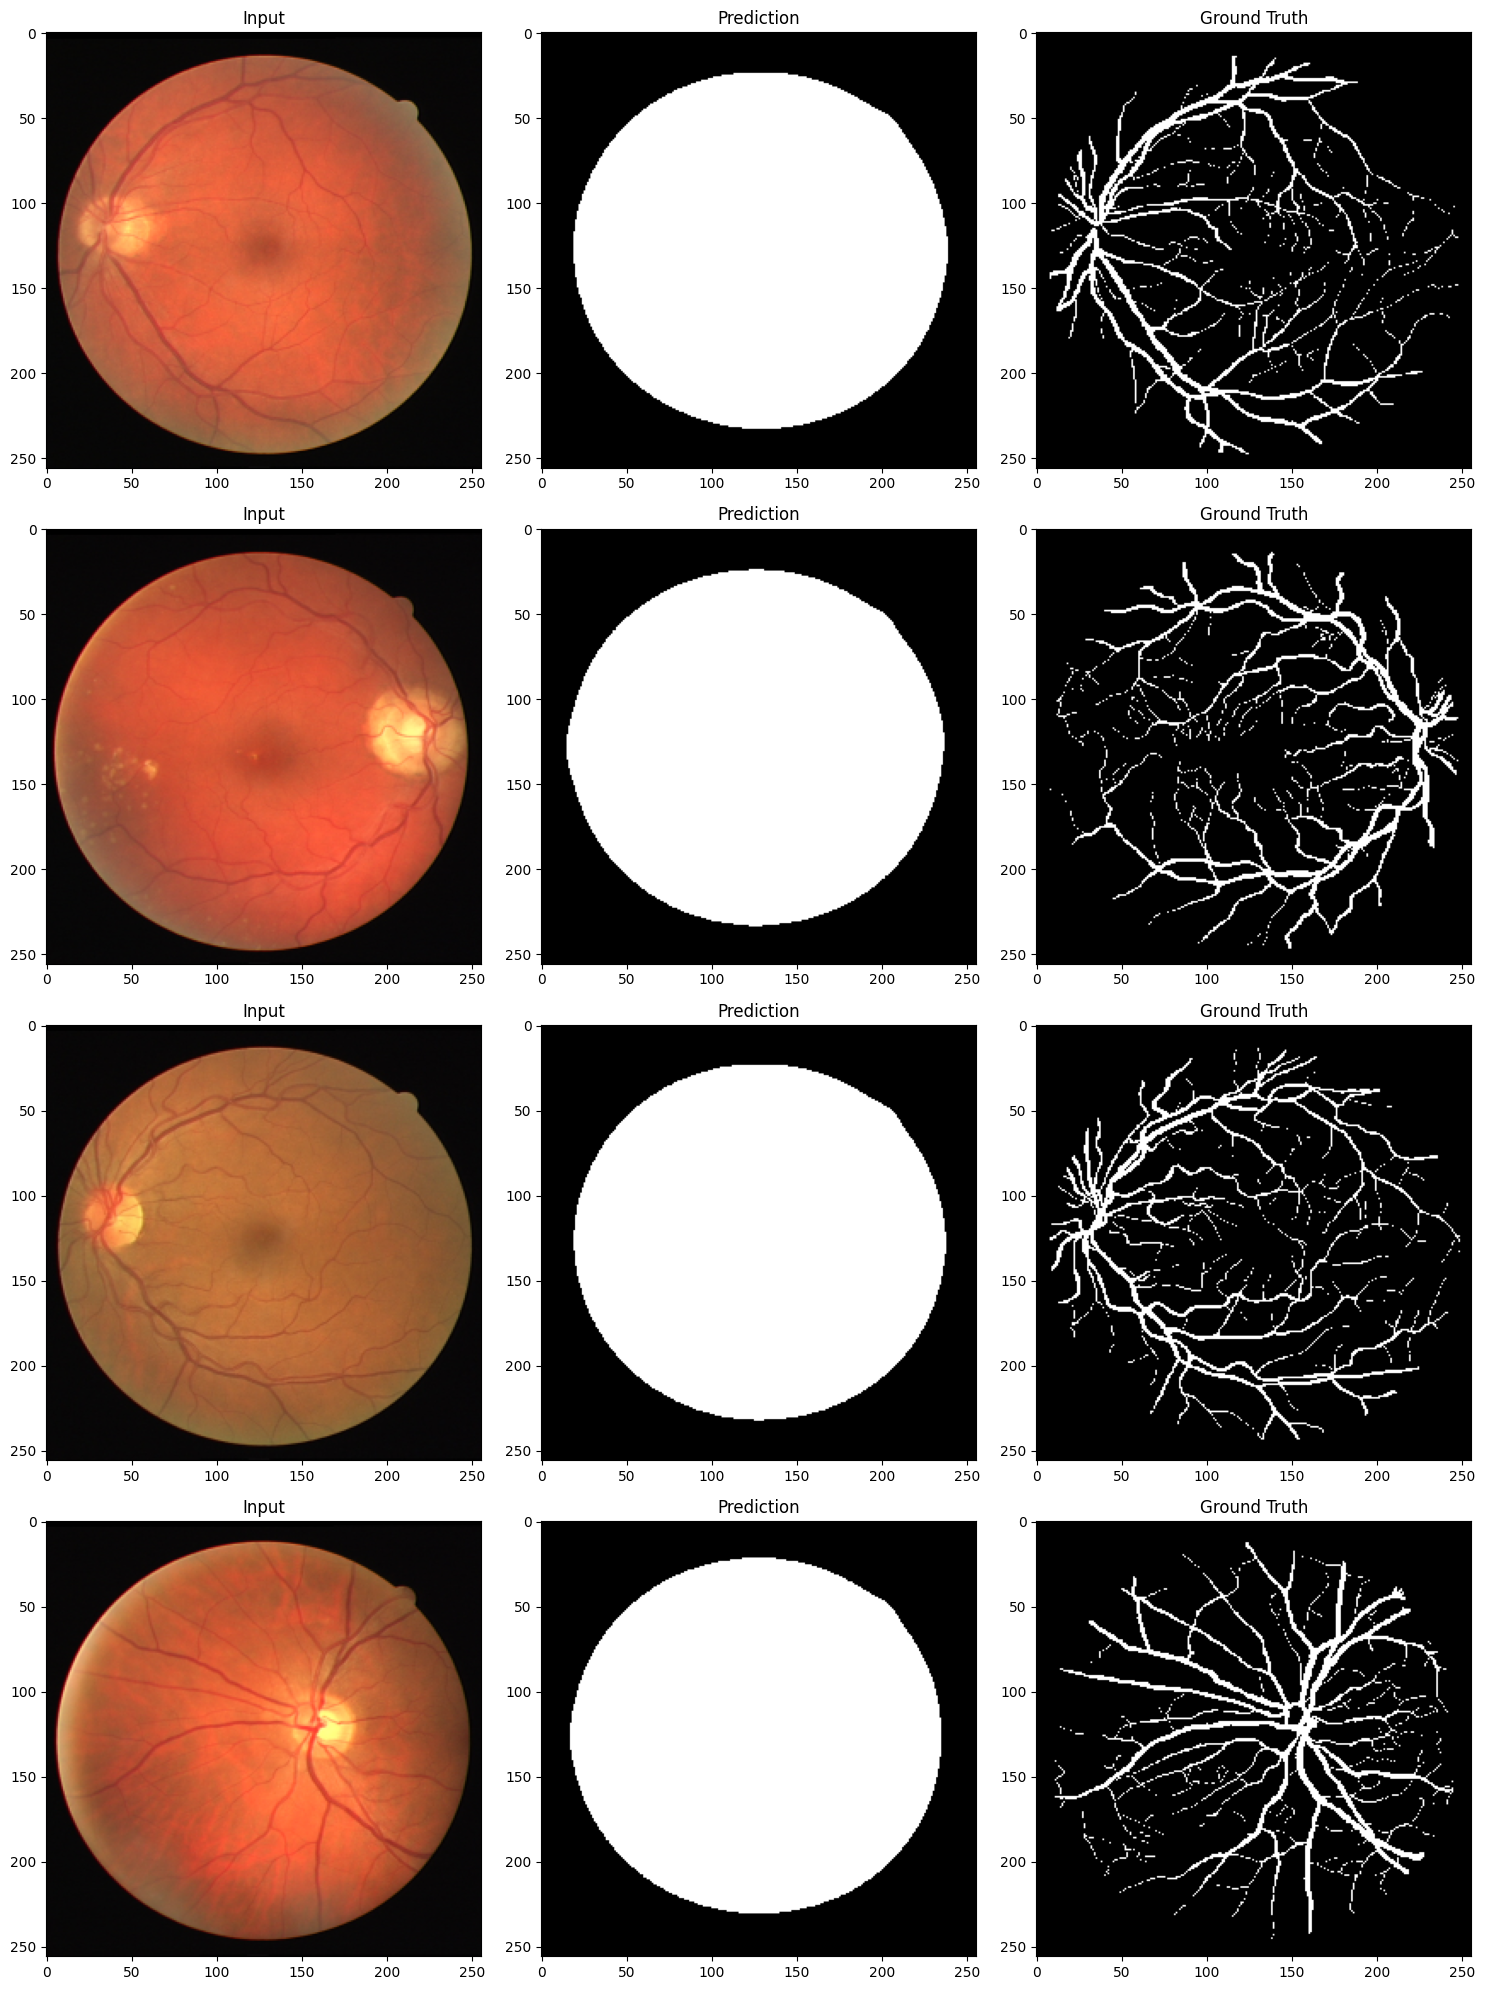

In [36]:
visualize_results(model, test_dataset, num_samples=4)